# <a id='1'>0. Sommaire</a>

In [32]:
import os
import pkg_resources
import types
from importlib import reload
import pickle

import numpy as np
import pandas as pd

import mlflow
import dagshub
import verstack
import re
from sklearn.metrics import fbeta_score
from pycaret.classification import *
import optuna
import outils_model

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
    print("{}=={}".format(*r))

optuna==3.0.4
verstack==3.7.1
dagshub==0.2.14.post1
mlflow==2.3.2
numpy==1.23.5
pandas==1.5.3
pycaret==3.0.2


# <a id='1'>2. Paramètres</a>

In [3]:
# os.environ["MLFLOW_TRACKING_USERNAME"] = "sefirotha/"
# os.environ['MLFLOW_TRACKING_PASSWORD'] = 'OC2023!'
#os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/sefirotha/OC-DS-P7"
# os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
# mlflow.set_tracking_uri("https://dagshub.com/sefirotha/OC-DS-P7.mlflow")

In [5]:
dagshub.init("OC-DS-P7_mlflow", "sefirotha", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/sefirotha/OC-DS-P7_mlflow.mlflow")
mlflow.start_run()

Repository initialized!

<ActiveRun: >

# <a id='1'>3. Data</a>

In [6]:
df = pd.read_pickle(r"..\Data\Processed_data\df_final_prot5.pkl")

In [7]:
with open(r'..\Data\Processed_data\var_cons_df.pickle', 'rb') as f:
    features_to_keep = pickle.load(f)

In [8]:
features_to_keep = features_to_keep['variables'].to_list()

In [9]:
features_to_ignore = list(set(df.keys().to_list()) - set(features_to_keep))
features_to_ignore.remove('TARGET')

In [10]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

# <a id='1'>4. Balancing</a>

## <a id='1'>4.1 SMOTE</a>

In [12]:
s = setup(data = train_df, 
          target = 'TARGET', 
          train_size = 0.8,
          ignore_features = features_to_ignore,
          log_data = True,
          log_experiment = "dagshub",
          experiment_name = "Balancing using SMOTE",
          fix_imbalance = True,
          fix_imbalance_method = 'SMOTE',
          normalize = True,
          normalize_method="robust",
          session_id=42)

,Description,Value
0,Session id,42
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 546)"
4,Transformed data shape,"(513792, 160)"
5,Transformed train set shape,"(452290, 160)"
6,Transformed test set shape,"(61502, 160)"
7,Ignore features,386
8,Numeric features,159
9,Preprocess,True


Please insert your repository owner_name/repo_name: sefirotha/OC-DS-P7_mlflow


2023/06/10 18:43:13 INFO mlflow.tracking.fluent: Experiment with name 'Balancing using SMOTE' does not exist. Creating a new experiment.


Uploading files (2) to "sefirotha/OC-DS-P7_mlflow"...

Upload finished successfully!

In [13]:
lgbm_smote = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9196,0.7753,0.0206,0.5541,0.0398,0.0342,0.0954
1,0.9195,0.7692,0.0237,0.5281,0.0453,0.0386,0.0990
2,0.9187,0.7718,0.0161,0.4156,0.0310,0.0251,0.0689
3,0.9192,0.7666,0.0191,0.4935,0.0368,0.0310,0.0849
4,0.9200,0.7707,0.0191,0.6441,0.0372,0.0327,0.1014
5,0.9194,0.7696,0.0191,0.5205,0.0369,0.0314,0.0881
6,0.9196,0.7762,0.0242,0.5455,0.0463,0.0397,0.1022
7,0.9203,0.7802,0.0267,0.6543,0.0513,0.0452,0.1210
8,0.9194,0.7636,0.0232,0.5169,0.0443,0.0377,0.0965


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
lgbm_smote_table = predict_model(lgbm_smote, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.0976,0.6034,0.9954,0.0818,0.1512,0.0023,0.0292


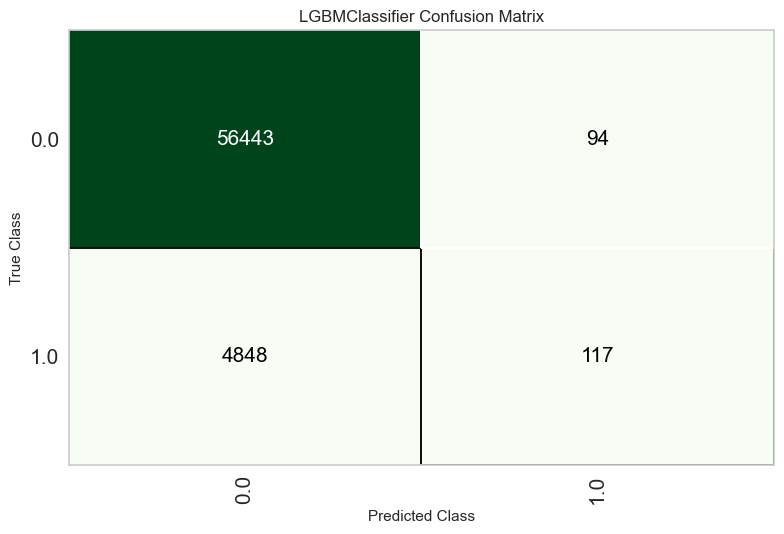

In [15]:
plot_model(lgbm_smote, "confusion_matrix")

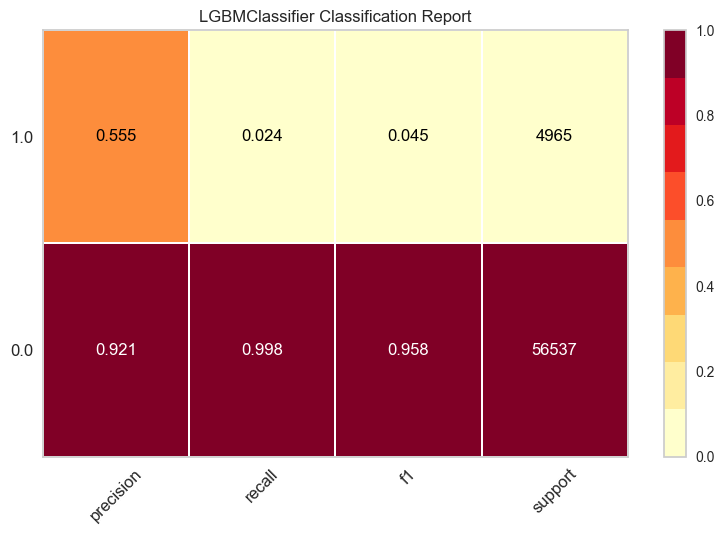

In [16]:
plot_model(lgbm_smote, "class_report")

In [36]:
outils_model.count_confusion_matrix_values(lgbm_smote_table, "TARGET", "prediction_label")

,category
FP,55478
TP,4942
TN,1059
FN,23


In [17]:
save_model(lgbm_smote, "test_lgbm_with_smote")

Transformation Pipeline and Model Successfully Saved


Uploading files (1) to "sefirotha/OC-DS-P7_mlflow"...

Upload finished successfully!

(Pipeline(memory=FastMemory(location=C:\Users\EBERTH~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CODE_GENDER', 'FLAG_OWN_CAR',
                                              'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                              'AMT_CREDIT', 'AMT_ANNUITY',
                                              'AMT_GOODS_PRICE',
                                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                              'DAYS_REGISTRATION',
                                              'DAYS_ID_PUBLIS...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                        

## <a id='1'>4.2 LGBM balancing function</a>

In [18]:
s = setup(data = train_df, 
          target = 'TARGET', 
          train_size = 0.8,
          ignore_features = features_to_ignore,
          log_data = True,
          log_experiment = "dagshub",
          experiment_name = "Balancing using LGBM function",
          normalize = True,
          normalize_method="robust",
          session_id=42)

,Description,Value
0,Session id,42
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 546)"
4,Transformed data shape,"(307507, 160)"
5,Transformed train set shape,"(246005, 160)"
6,Transformed test set shape,"(61502, 160)"
7,Ignore features,386
8,Numeric features,159
9,Preprocess,True


Please insert your repository owner_name/repo_name: sefirotha/OC-DS-P7_mlflow


2023/06/10 19:03:36 INFO mlflow.tracking.fluent: Experiment with name 'Balancing using LGBM function' does not exist. Creating a new experiment.


Uploading files (2) to "sefirotha/OC-DS-P7_mlflow"...

Upload finished successfully!

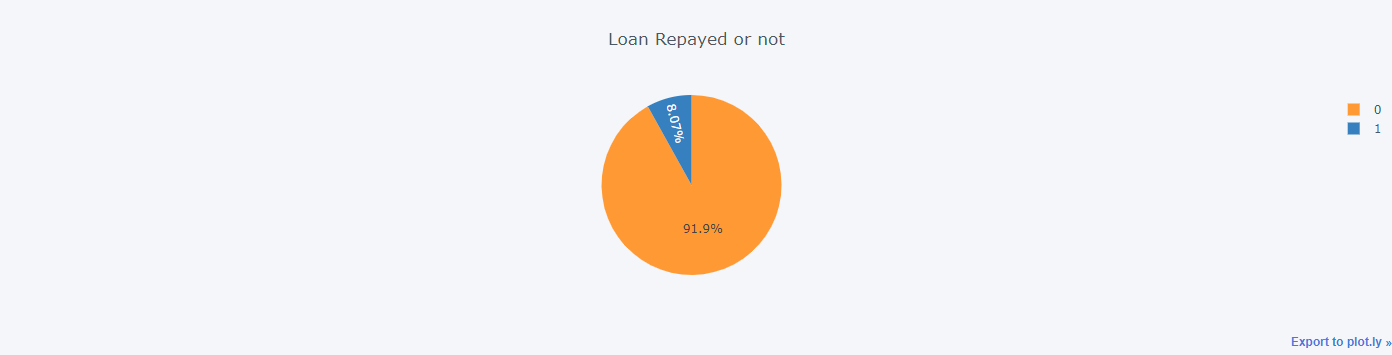

In [19]:
scale_pos_weight = float(8.07/91.9)

In [20]:
lgbm_scale_pos_weight = create_model("lightgbm", scale_pos_weight = scale_pos_weight)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9194,0.7777,0.0035,0.6364,0.0070,0.0061,0.0431
1,0.9194,0.7697,0.0015,0.7500,0.0030,0.0027,0.0313
2,0.9191,0.7722,0.0015,0.3333,0.0030,0.0023,0.0177
3,0.9193,0.7666,0.0020,0.5714,0.0040,0.0034,0.0304
4,0.9193,0.7742,0.0020,0.5714,0.0040,0.0034,0.0304
5,0.9194,0.7742,0.0025,0.7143,0.0050,0.0045,0.0392
6,0.9193,0.7757,0.0020,0.6667,0.0040,0.0035,0.0336
7,0.9193,0.7775,0.0025,0.5556,0.0050,0.0043,0.0333
8,0.9194,0.7653,0.0015,1.0000,0.0030,0.0028,0.0373


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
lgbm_scale_pos_weight_table = predict_model(lgbm_scale_pos_weight, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9194,0.7755,0.0022,0.6875,0.0044,0.0039,0.0359


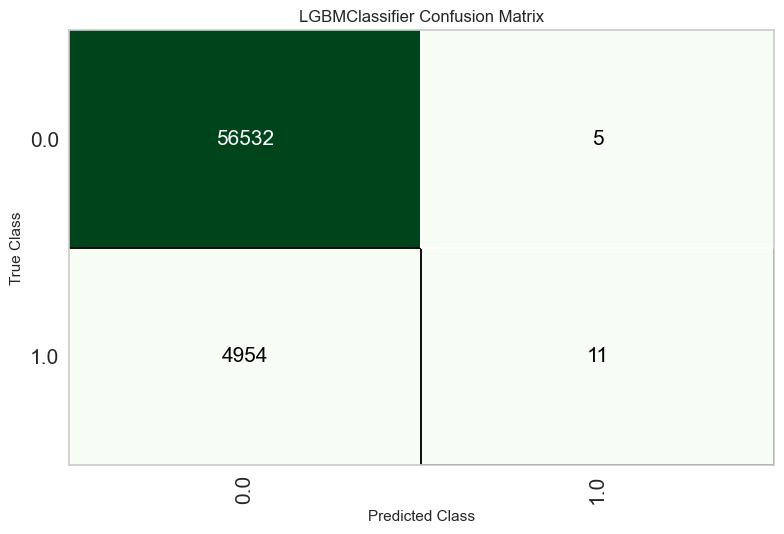

In [22]:
plot_model(lgbm_scale_pos_weight, "confusion_matrix")

In [41]:
outils_model.count_confusion_matrix_values(lgbm_scale_pos_weight_table, "TARGET", "prediction_label")

,category
TN,56532
FN,4954
TP,11
FP,5


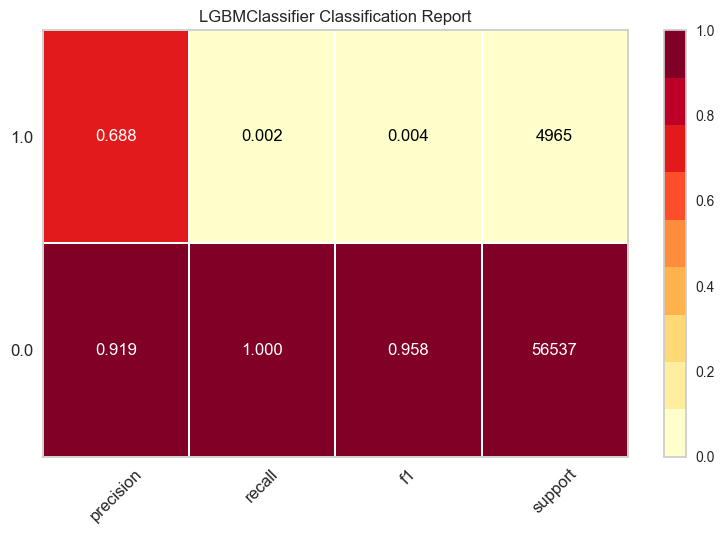

In [23]:
plot_model(lgbm_scale_pos_weight, "class_report")

In [24]:
save_model(lgbm_scale_pos_weight, "test_lgbm_scale_pos_weight")

Transformation Pipeline and Model Successfully Saved


Uploading files (1) to "sefirotha/OC-DS-P7_mlflow"...

Upload finished successfully!

(Pipeline(memory=FastMemory(location=C:\Users\EBERTH~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CODE_GENDER', 'FLAG_OWN_CAR',
                                              'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                              'AMT_CREDIT', 'AMT_ANNUITY',
                                              'AMT_GOODS_PRICE',
                                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                              'DAYS_REGISTRATION',
                                              'DAYS_ID_PUBLIS...
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20, min_child_weight=0.001,
                   

In [25]:
lgbm_class_weight = create_model("lightgbm", class_weight  = "balanced")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7239,0.7824,0.6974,0.1828,0.2897,0.1855,0.2500
1,0.7246,0.7750,0.6868,0.1815,0.2871,0.1827,0.2453
2,0.7298,0.7788,0.6813,0.1837,0.2893,0.1858,0.2471
3,0.7218,0.7718,0.6793,0.1785,0.2827,0.1776,0.2390
4,0.7304,0.7823,0.6979,0.1868,0.2948,0.1918,0.2559
5,0.7237,0.7786,0.6893,0.1813,0.2872,0.1827,0.2458
6,0.7265,0.7818,0.6969,0.1843,0.2915,0.1878,0.2520
7,0.7196,0.7828,0.7054,0.1816,0.2889,0.1841,0.2503
8,0.7284,0.7703,0.6767,0.1820,0.2869,0.1829,0.2435


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
lgbm_class_weight_table = predict_model(lgbm_class_weight, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7264,0.7808,0.6922,0.1835,0.2900,0.1862,0.2496


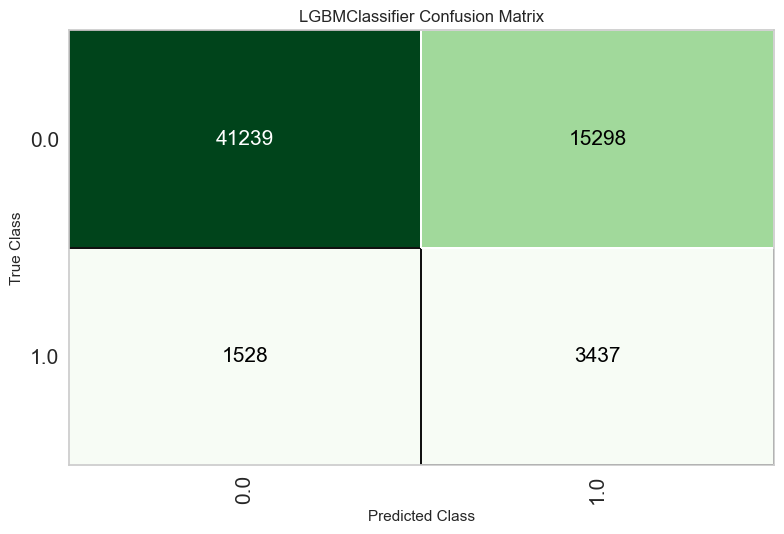

In [27]:
plot_model(lgbm_class_weight, "confusion_matrix")

In [29]:
save_model(lgbm_class_weight, "test_lgbm_class_weight")

Transformation Pipeline and Model Successfully Saved


Uploading files (1) to "sefirotha/OC-DS-P7_mlflow"...

Upload finished successfully!

(Pipeline(memory=FastMemory(location=C:\Users\EBERTH~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['CODE_GENDER', 'FLAG_OWN_CAR',
                                              'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                              'AMT_CREDIT', 'AMT_ANNUITY',
                                              'AMT_GOODS_PRICE',
                                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                              'DAYS_REGISTRATION',
                                              'DAYS_ID_PUBLIS...
                  LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                  

In [42]:
outils_model.count_confusion_matrix_values(lgbm_class_weight_table, "TARGET", "prediction_label")

,category
TN,41239
FP,15298
TP,3437
FN,1528


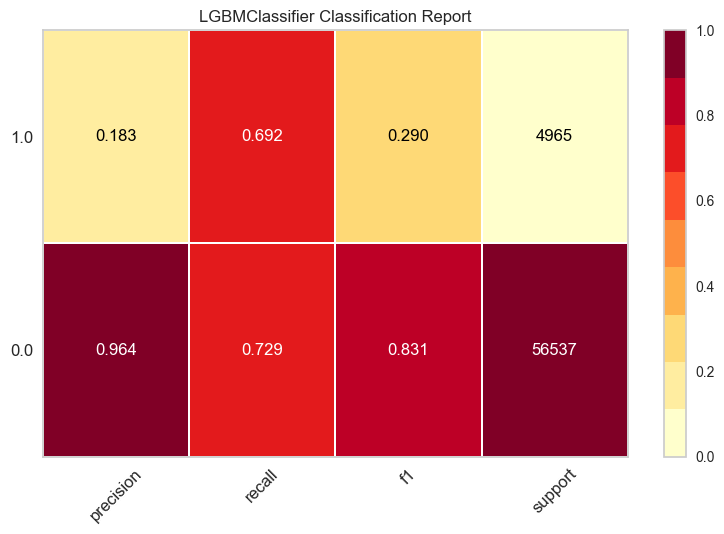

In [28]:
plot_model(lgbm_class_weight, "class_report")

In [30]:
mlflow.end_run()